In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"baharehgholami","key":"965dcde1ded52e1b07a539842dbad8fc"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:05<00:00, 40.5MB/s]
100% 2.29G/2.29G [01:05<00:00, 37.5MB/s]


In [ ]:
!unzip "/content/chest-xray-pneumonia.zip"

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import WeightedRandomSampler
import  torchvision
import torch.nn.functional as F 
from torch import nn,optim
from torchvision import transforms as T,datasets,models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
#from collections import OrderedDict
from tqdm import tqdm
#pd.options.plotting.backend = "plotly"
from torch import nn, optim
#from torch.autograd import Variable
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from time import sleep
!mkdir "/content/models"

Creating train dataframe

In [ ]:
data_normal=[os.path.join("/content/chest_xray/train/NORMAL",path) for path in os.listdir("/content/chest_xray/train/NORMAL")]
data_pneumonia=[os.path.join("/content/chest_xray/train/PNEUMONIA",path) for path in os.listdir("/content/chest_xray/train/PNEUMONIA")]
data_normal_labels=[0 for x in range(len(data_normal))]
data_pneumonia_labels=[1 for x in range(len(data_pneumonia))]
data_normal_df=pd.DataFrame({"path":data_normal,"label":data_normal_labels})
data_pneumonia_df=pd.DataFrame({"path":data_pneumonia,"label":data_pneumonia_labels})

In [ ]:
data_df=pd.concat([data_pneumonia_df,data_normal_df],axis=0,ignore_index=True)

In [ ]:
data_df

In [ ]:
#train val split
from sklearn.model_selection import train_test_split
train, valid=train_test_split(data_df,test_size=0.2, shuffle=True)

In [ ]:
train=train.reset_index(drop=True)

In [ ]:
valid=valid.reset_index(drop=True)

In [ ]:
print(train["label"].value_counts())

1    3119
0    1053
Name: label, dtype: int64


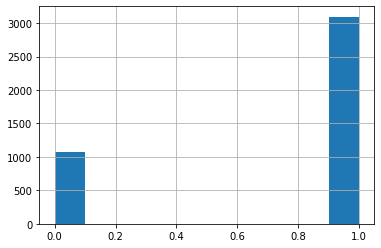

In [ ]:
train["label"].hist()

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

<Figure size 1440x1440 with 0 Axes>

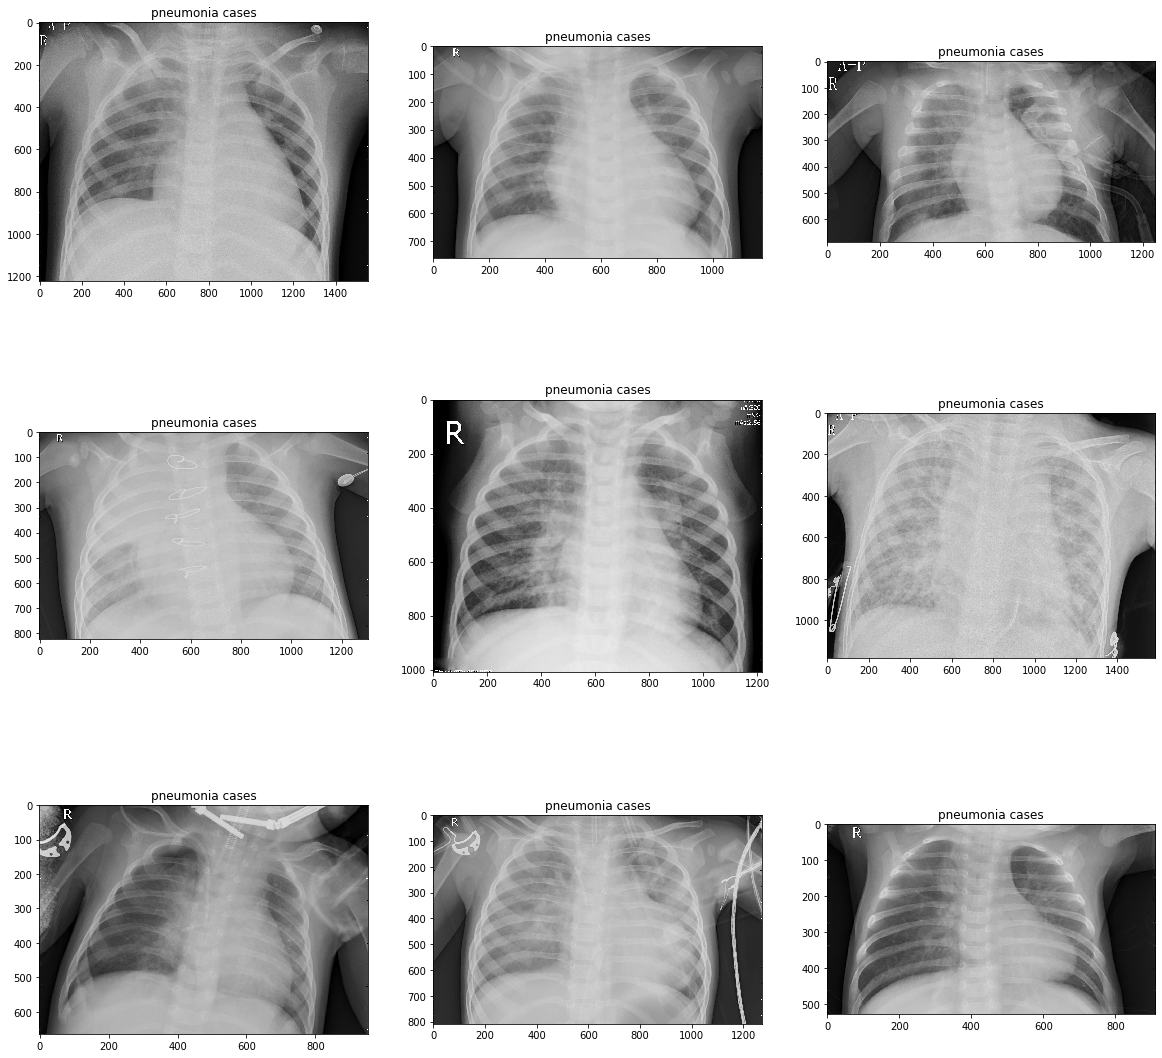

In [ ]:
#pneumonia images
import random
for i,path in enumerate(random.sample(data_pneumonia,nrows*ncols)):
  img=Image.open(path)
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(np.array(img),interpolation='nearest',cmap="gray")
  plt.title("pneumonia cases")


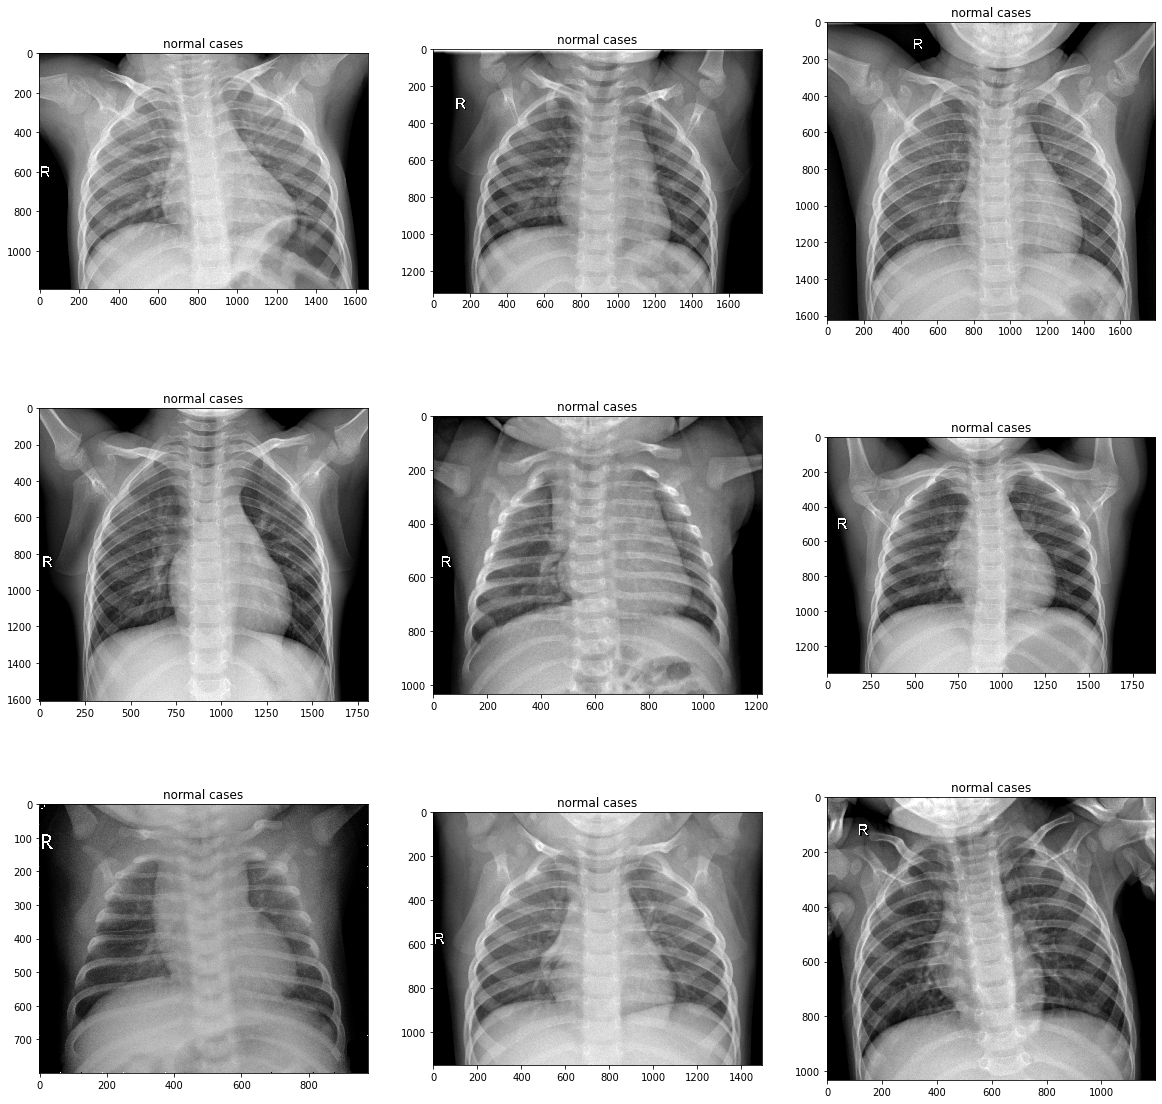

In [ ]:
#normal images
import random
for i,path in enumerate(random.sample(data_normal,nrows*ncols)):
  img=Image.open(path)
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(np.array(img),interpolation='nearest',cmap="gray")
  plt.title("normal cases")

In [ ]:
#custom dataset:
class xray_dataset(Dataset):
  def __init__(self,df,transform=True):
    self.df=df
    self.transform=transform

  def __len__(self):
    return(len(self.df["path"].values))

  def __getitem__(self, index):

    image = Image.open(self.df["path"][index]).convert('RGB') # PIL image
    if self.transform:
       image = self.transform(image)
    label=torch.tensor(self.df["label"][index])

    return image,label

In [ ]:
data_dir = "/content/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'
import torchvision.transforms as T
def data_transforms(phase = None):
    
    if phase == TRAIN:

        data_T = T.Compose([
            
                T.Resize(size = (256,256)),
                #T.Resize(size = (224,224)),
                T.RandomRotation(degrees = (-20,+20)),
                T.CenterCrop(size=224),
                T.ToTensor(),
                T.Normalize([0.4823, 0.4823, 0.4823],[0.2374, 0.2374, 0.2374]),
                T.RandomHorizontalFlip(
                 p=0.5
                 ),  # Flips the image horizontally with probability 0.5
                T.RandomVerticalFlip(
                 p=0.05
        )
        ])
    
    elif phase == TEST or phase == VAL:
              data_T = T.Compose([

                T.Resize(size = (224,224)),
                T.ToTensor(),
                T.Normalize([0.4823, 0.4823, 0.4823],[0.2374, 0.2374, 0.2374])
        ])
        
    return data_T

In [ ]:
train_ds=xray_dataset(train,transform=data_transforms(TRAIN))
valid_ds=xray_dataset(valid,transform=data_transforms(VAL))

In [ ]:
class_weights=[3,1]
sample_weights=[0]*len(train_ds)
for idx, (data,label) in enumerate(train_ds):
  try:
    class_weight=class_weights[label]
    sample_weights[idx]=class_weight
  except:
      print("finish")



In [ ]:
sampler=WeightedRandomSampler(sample_weights,num_samples=len(sample_weights),replacement=True)

In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler)
valid_dl = DataLoader(valid_ds, batch_size=32)

In [ ]:
def show(img,y,color=False):
  # convert tensor to numpy array
  npimg = img.numpy()
  # Convert to H*W*C shape
  npimg_tr=np.transpose(npimg, (1,2,0))
  if color==False:
    npimg_tr=npimg_tr[:,:,0]
    plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
  else:
  # display images
    plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

image indices: [ 716 1730 4136 4125]
torch.Size([3, 228, 906])


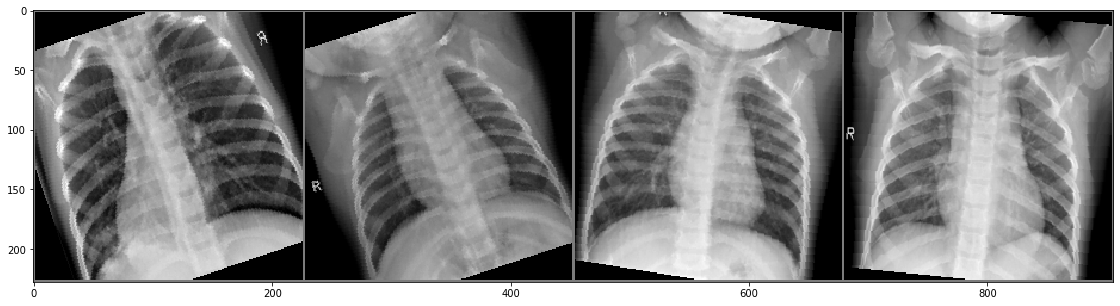

In [ ]:
from torchvision import utils
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]
x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)
plt.rcParams['figure.figsize'] = (20.0, 5)
show(x_grid_train,y_grid_train)

In [ ]:
test_normal=[os.path.join("/content/chest_xray/test/NORMAL",path) for path in os.listdir("/content/chest_xray/test/NORMAL")]
test_pneumonia=[os.path.join("/content/chest_xray/test/PNEUMONIA",path) for path in os.listdir("/content/chest_xray/test/PNEUMONIA")]
#label 0 for normal xray
test_normal_labels=[0 for x in range(len(test_normal))]
test_pneumonia_labels=[1 for x in range(len(test_pneumonia))]
test_normal_df=pd.DataFrame({"path":test_normal,"label":test_normal_labels})
test_pneumonia_df=pd.DataFrame({"path":test_pneumonia,"label":test_pneumonia_labels})

In [ ]:
test_df=pd.concat([test_pneumonia_df,test_normal_df],axis=0,ignore_index=True)
test_ds=xray_dataset(test_df,transform=data_transforms(VAL))
test_dl=DataLoader(test_ds, batch_size=32)

In [ ]:
len(test_ds)

624

In [ ]:
import torch.nn as nn
def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)


# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"]  
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,padding='same', stride=1)
        self.bn1=nn.BatchNorm2d(init_f)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3, padding='same', stride=1)
        self.bn2=nn.BatchNorm2d(2*init_f)
        
        self.conv3 = nn.Conv2d(2*init_f, 2*init_f, kernel_size=3,padding='same', stride=1)
        self.bn3=nn.BatchNorm2d(2*init_f)

        self.conv4 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding='same', stride=1)
        self.bn4=nn.BatchNorm2d(4*init_f)

        self.conv5 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding='same', stride=1)
        self.bn5=nn.BatchNorm2d(8*init_f)
                
        self.num_flatten=256*7*7
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2, 2)
        x=F.dropout(x, 0.1)
        
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x, 2, 2)
        x=F.dropout(x, 0.2)

        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.max_pool2d(x, 2, 2)
        x=F.dropout(x, 0.2)

        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x=F.dropout(x, 0.2)
        x = self.fc2(x)
        return x

In [ ]:
# dict to define model parameters
params_model={
"input_shape": (3,224,224),
"initial_filters": 32,
"num_fc1": 300,
"num_classes": 2
}
# create model
model = Net(params_model)

In [ ]:
# HyperParameters
device = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
#BATCH_SIZE = 64
LEARNING_RATE = 1e-2

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224),device=device)

In [ ]:
model=model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.3, patience=2,verbose=1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']
    
current_lr=get_lr(optimizer)
current_lr

0.01

In [ ]:
def initialize_weights(model):
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


model.apply(initialize_weights)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12544, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
def train_fn(model, optimizer, criterion, trainloader, device,epoch,train_history):
    running_loss = 0
    model.to(device)
    model.train()
    tqdm_bar = tqdm(trainloader, desc=f'Training Epoch {epoch+1} ', total=int(len(trainloader)))
    for i, (images, labels) in enumerate(tqdm_bar):
            images = images.to(device=device)
            labels = labels.to(device=device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tqdm_bar.set_postfix(train_loss=loss.item())
            #sleep(0.1)

    epoch_train_loss=running_loss/len(trainloader)
    train_history.append(epoch_train_loss)
    return epoch_train_loss

In [ ]:
#validation
def valid_fn(model, criterion, dataloader, device,epoch,valid_history):
    model.to(device)
    num_correct = 0
    num_samples = 0
    running_loss_val=0
    acc=[]
    model.eval()
    with torch.no_grad():
        tqdm_bar = tqdm(dataloader, desc=f'validation Epoch {epoch+1} ', total=int(len(dataloader)))
        for i, (images, labels) in enumerate(tqdm_bar):
              images = images.to(device=device)
              labels = labels.to(device=device)
              output_v = model(images)
              val_loss= criterion(output_v, labels)
              running_loss_val+=val_loss.item()
              _, predictions = output_v.max(1)
              num_correct += (predictions == labels).sum()
              num_samples += predictions.size(0)
              tqdm_bar.set_postfix(valid_loss=val_loss.item())
              sleep(0.1)
    accuracy=num_correct/num_samples
    accuracy=accuracy.to("cpu")
    epoch_val_loss= running_loss_val/len(dataloader)
    valid_history.append(epoch_val_loss)
    return epoch_val_loss, accuracy                                                                 

In [ ]:
path2weights="/content/models/weights.pt"
def train_loop(model):
  valid_history=[]
  train_history=[]
  acc=[]
  #best_loss=float('inf')
  best_acc=0
  best_model_wts = copy.deepcopy(model.state_dict())
  for epoch in range(EPOCHS):
          train_loss = train_fn(model, optimizer, criterion, train_dl, device, epoch, 
                                train_history=train_history)
          current_lr=get_lr(optimizer)
          print(f"EPOCH: {epoch+1}, train_loss: {train_loss}, learning rate: {current_lr}")
          valid_loss, accuracy = valid_fn(model, criterion, valid_dl, device, epoch,
                                          valid_history=valid_history)
          acc.append(accuracy)
          print(f" EPOCH: {epoch+1}, valid_loss: {valid_loss}, accuracy:{accuracy}")

          if accuracy > best_acc:
              best_acc = accuracy
              best_model_wts = copy.deepcopy(model.state_dict())

          #if valid_loss < best_loss:
              #best_loss = valid_loss
              #best_model_wts = copy.deepcopy(model.state_dict())
              # store weights into a local file
              torch.save(model.state_dict(), path2weights)
              print("Copied best model weights!")

          lr_scheduler.step(valid_loss)
          if current_lr != get_lr(optimizer):
                print("Loading best model weights!")
                model.load_state_dict(best_model_wts) 

          model.load_state_dict(best_model_wts)
          
  return model, valid_history, train_history, acc


In [ ]:
model, valid_history, train_history, acc=train_loop(model)

Training Epoch 1 : 100%|██████████| 131/131 [01:48<00:00,  1.20it/s, train_loss=0.258]


EPOCH: 1, train_loss: 4.93713119574858, learning rate: 0.01


validation Epoch 1 : 100%|██████████| 33/33 [00:20<00:00,  1.62it/s, valid_loss=0.441]


 EPOCH: 1, valid_loss: 0.43093103554212686, accuracy:0.8544061183929443
Copied best model weights!


Training Epoch 2 : 100%|██████████| 131/131 [01:43<00:00,  1.27it/s, train_loss=0.0969]


EPOCH: 2, train_loss: 0.29794870080952424, learning rate: 0.01


validation Epoch 2 : 100%|██████████| 33/33 [00:20<00:00,  1.61it/s, valid_loss=0.233]


 EPOCH: 2, valid_loss: 0.2597950500520793, accuracy:0.8888888955116272
Copied best model weights!


Training Epoch 3 : 100%|██████████| 131/131 [01:40<00:00,  1.31it/s, train_loss=0.13]


EPOCH: 3, train_loss: 0.25755729446656833, learning rate: 0.01


validation Epoch 3 : 100%|██████████| 33/33 [00:20<00:00,  1.63it/s, valid_loss=0.344]


 EPOCH: 3, valid_loss: 0.28899992596019397, accuracy:0.8850574493408203


Training Epoch 4 : 100%|██████████| 131/131 [01:40<00:00,  1.30it/s, train_loss=0.178]


EPOCH: 4, train_loss: 0.30003734734904675, learning rate: 0.01


validation Epoch 4 : 100%|██████████| 33/33 [00:20<00:00,  1.65it/s, valid_loss=0.458]


 EPOCH: 4, valid_loss: 0.5614279224113985, accuracy:0.7662835121154785


Training Epoch 5 : 100%|██████████| 131/131 [01:40<00:00,  1.30it/s, train_loss=0.0508]


EPOCH: 5, train_loss: 0.27130825061152, learning rate: 0.01


validation Epoch 5 : 100%|██████████| 33/33 [00:20<00:00,  1.64it/s, valid_loss=0.188]


 EPOCH: 5, valid_loss: 0.32787147570740094, accuracy:0.8773946166038513
Epoch 00005: reducing learning rate of group 0 to 3.0000e-03.
Loading best model weights!


Training Epoch 6 : 100%|██████████| 131/131 [01:38<00:00,  1.33it/s, train_loss=0.229]


EPOCH: 6, train_loss: 0.2434909986118779, learning rate: 0.003


validation Epoch 6 : 100%|██████████| 33/33 [00:20<00:00,  1.60it/s, valid_loss=0.233]


 EPOCH: 6, valid_loss: 0.2642009477272178, accuracy:0.9109195470809937
Copied best model weights!


Training Epoch 7 : 100%|██████████| 131/131 [01:38<00:00,  1.33it/s, train_loss=0.101]


EPOCH: 7, train_loss: 0.19245063192175546, learning rate: 0.003


validation Epoch 7 : 100%|██████████| 33/33 [00:20<00:00,  1.65it/s, valid_loss=0.294]


 EPOCH: 7, valid_loss: 0.32487070176637534, accuracy:0.8917624354362488


Training Epoch 8 : 100%|██████████| 131/131 [01:39<00:00,  1.32it/s, train_loss=0.112]


EPOCH: 8, train_loss: 0.1998951551824353, learning rate: 0.003


validation Epoch 8 : 100%|██████████| 33/33 [00:20<00:00,  1.64it/s, valid_loss=0.342]


 EPOCH: 8, valid_loss: 0.46785804177775525, accuracy:0.8745210766792297
Epoch 00008: reducing learning rate of group 0 to 9.0000e-04.
Loading best model weights!


Training Epoch 9 : 100%|██████████| 131/131 [01:38<00:00,  1.33it/s, train_loss=0.0741]


EPOCH: 9, train_loss: 0.18610038339579835, learning rate: 0.0009


validation Epoch 9 : 100%|██████████| 33/33 [00:20<00:00,  1.64it/s, valid_loss=0.232]


 EPOCH: 9, valid_loss: 0.2794247816006343, accuracy:0.9051724076271057


Training Epoch 10 : 100%|██████████| 131/131 [01:40<00:00,  1.31it/s, train_loss=0.18]


EPOCH: 10, train_loss: 0.18698572836645688, learning rate: 0.0009


validation Epoch 10 : 100%|██████████| 33/33 [00:20<00:00,  1.64it/s, valid_loss=0.264]


 EPOCH: 10, valid_loss: 0.25516382491949835, accuracy:0.9070881009101868


Training Epoch 11 : 100%|██████████| 131/131 [01:40<00:00,  1.31it/s, train_loss=0.225]


EPOCH: 11, train_loss: 0.18960032987458106, learning rate: 0.0009


validation Epoch 11 : 100%|██████████| 33/33 [00:20<00:00,  1.62it/s, valid_loss=0.271]


 EPOCH: 11, valid_loss: 0.2068232074379921, accuracy:0.9185823798179626
Copied best model weights!


Training Epoch 12 : 100%|██████████| 131/131 [01:41<00:00,  1.30it/s, train_loss=0.0438]


EPOCH: 12, train_loss: 0.16370410312905567, learning rate: 0.0009


validation Epoch 12 : 100%|██████████| 33/33 [00:20<00:00,  1.64it/s, valid_loss=0.252]


 EPOCH: 12, valid_loss: 0.251276849458615, accuracy:0.9214559197425842
Copied best model weights!


Training Epoch 13 : 100%|██████████| 131/131 [01:40<00:00,  1.31it/s, train_loss=0.056]


EPOCH: 13, train_loss: 0.16772390306280313, learning rate: 0.0009


validation Epoch 13 : 100%|██████████| 33/33 [00:19<00:00,  1.65it/s, valid_loss=0.304]


 EPOCH: 13, valid_loss: 0.26376742621262866, accuracy:0.9109195470809937


Training Epoch 14 : 100%|██████████| 131/131 [01:38<00:00,  1.32it/s, train_loss=0.161]


EPOCH: 14, train_loss: 0.1609617344153519, learning rate: 0.0009


validation Epoch 14 : 100%|██████████| 33/33 [00:20<00:00,  1.63it/s, valid_loss=0.308]


 EPOCH: 14, valid_loss: 0.33647047434792376, accuracy:0.8860152959823608
Epoch 00014: reducing learning rate of group 0 to 2.7000e-04.
Loading best model weights!


Training Epoch 15 : 100%|██████████| 131/131 [01:39<00:00,  1.31it/s, train_loss=0.147]


EPOCH: 15, train_loss: 0.1455584756660325, learning rate: 0.00027


validation Epoch 15 : 100%|██████████| 33/33 [00:20<00:00,  1.64it/s, valid_loss=0.29]


 EPOCH: 15, valid_loss: 0.26061468108585384, accuracy:0.9137930870056152


Training Epoch 16 : 100%|██████████| 131/131 [01:41<00:00,  1.29it/s, train_loss=0.794]


EPOCH: 16, train_loss: 0.16901981876096653, learning rate: 0.00027


validation Epoch 16 : 100%|██████████| 33/33 [00:20<00:00,  1.64it/s, valid_loss=0.241]


 EPOCH: 16, valid_loss: 0.25082034414464777, accuracy:0.9128352403640747


Training Epoch 17 : 100%|██████████| 131/131 [01:40<00:00,  1.30it/s, train_loss=0.0404]


EPOCH: 17, train_loss: 0.15764015086905192, learning rate: 0.00027


validation Epoch 17 : 100%|██████████| 33/33 [00:20<00:00,  1.63it/s, valid_loss=0.22]


 EPOCH: 17, valid_loss: 0.27100067179311405, accuracy:0.9051724076271057
Epoch 00017: reducing learning rate of group 0 to 8.1000e-05.
Loading best model weights!


Training Epoch 18 : 100%|██████████| 131/131 [01:41<00:00,  1.29it/s, train_loss=0.0249]


EPOCH: 18, train_loss: 0.1611115177169101, learning rate: 8.1e-05


validation Epoch 18 : 100%|██████████| 33/33 [00:20<00:00,  1.63it/s, valid_loss=0.142]


 EPOCH: 18, valid_loss: 0.24307095823865948, accuracy:0.9147509336471558


Training Epoch 19 : 100%|██████████| 131/131 [01:40<00:00,  1.30it/s, train_loss=0.18]


EPOCH: 19, train_loss: 0.1524048089298583, learning rate: 8.1e-05


validation Epoch 19 : 100%|██████████| 33/33 [00:20<00:00,  1.62it/s, valid_loss=0.273]


 EPOCH: 19, valid_loss: 0.23869759262059675, accuracy:0.9204980731010437


Training Epoch 20 : 100%|██████████| 131/131 [01:38<00:00,  1.32it/s, train_loss=0.0622]


EPOCH: 20, train_loss: 0.15009846939271643, learning rate: 8.1e-05


validation Epoch 20 : 100%|██████████| 33/33 [00:20<00:00,  1.62it/s, valid_loss=0.258]

 EPOCH: 20, valid_loss: 0.251319264597965, accuracy:0.9204980731010437
Epoch 00020: reducing learning rate of group 0 to 2.4300e-05.
Loading best model weights!


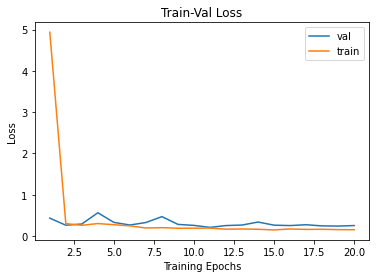

In [ ]:
# Train-Validation Progress
num_epochs=EPOCHS

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),valid_history,label="val")
plt.plot(range(1,num_epochs+1),train_history,label="train")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


In [ ]:
acc2=[]
for ac in acc:
  acc2.append(ac.to("cpu"))


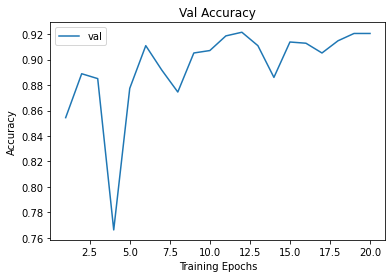

In [ ]:
num_epochs=EPOCHS
# plot accuracy progress
plt.title("Val Accuracy")
plt.plot(range(1,num_epochs+1),acc2,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
num_correct=0
num_samples=0
for x, y in test_dl:
      x = x.to(device=device)
      y = y.to(device=device)
      scores=model(x)
      _, predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)
print("accuarcy",num_correct/num_samples)

accuarcy tensor(0.8429, device='cuda:0')
